In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

import plot_analysis_result as plot
import importlib
import glob
importlib.reload(plot)
input_folder = '/gladstone/engelhardt/lab/hvu/RNA_rates/solver_analysis/constant/after_Smooth/question_5'
output_folder = '/gladstone/engelhardt/lab/hvu/RNA_rates/solver_analysis/constant/after_Smooth/question_5'
fn_list = glob.glob(f'{input_folder}/result_*.txt.gz')
os.makedirs(output_folder, exist_ok=True)
import importlib
importlib.reload(plot)
result_df = plot.read_all_result_files(input_folder, methods=['simpleSmooth'])

In [4]:
# plot5: Compare the performance of different solvers, across different true_h for only one case:
def read_one_result_raw(fn, summ_df, methods = ['simpleSolver', 'simpleSmooth', 'bayesLinearSolver', 'bayesRBFSolver', 'logNormalSolver']):
    '''
    Read one result file and return the results as a dictionary
    :param fn: str, the filename
    :return: dict
    '''
    df = pd.read_csv(fn, sep='\t', header=0, index_col=None)  # start, end, true_h and then all the diffemrent solver results
    file_index = int(fn.split('/')[-1].split('.')[0].split('_')[-1])
    try:
        df = df.rename(columns={'txrate': 'true_h'})
    except:
        pass
    h_bin =summ_df.loc[file_index, 'h_bin']
    lambda_smooth = summ_df.loc[file_index, 'lambda_smooth']
    vary_fold = summ_df.loc[file_index, 'vary_fold']
    vary_bin_kb = summ_df.loc[file_index, 'vary_bin_kb']
    df['h_bin'] = h_bin
    df['lambda_smooth'] = lambda_smooth
    df['vary_fold'] = vary_fold
    df['vary_bin_kb'] = vary_bin_kb
    return df

run_fn_list = [f'{input_folder}/result_{i}.txt.gz' for i in range(len(fn_list))]
run_df_list = list(map(lambda x: read_one_result_raw(x, result_df, methods = ['simpleSmooth']), run_fn_list))
run_df = pd.concat(run_df_list)

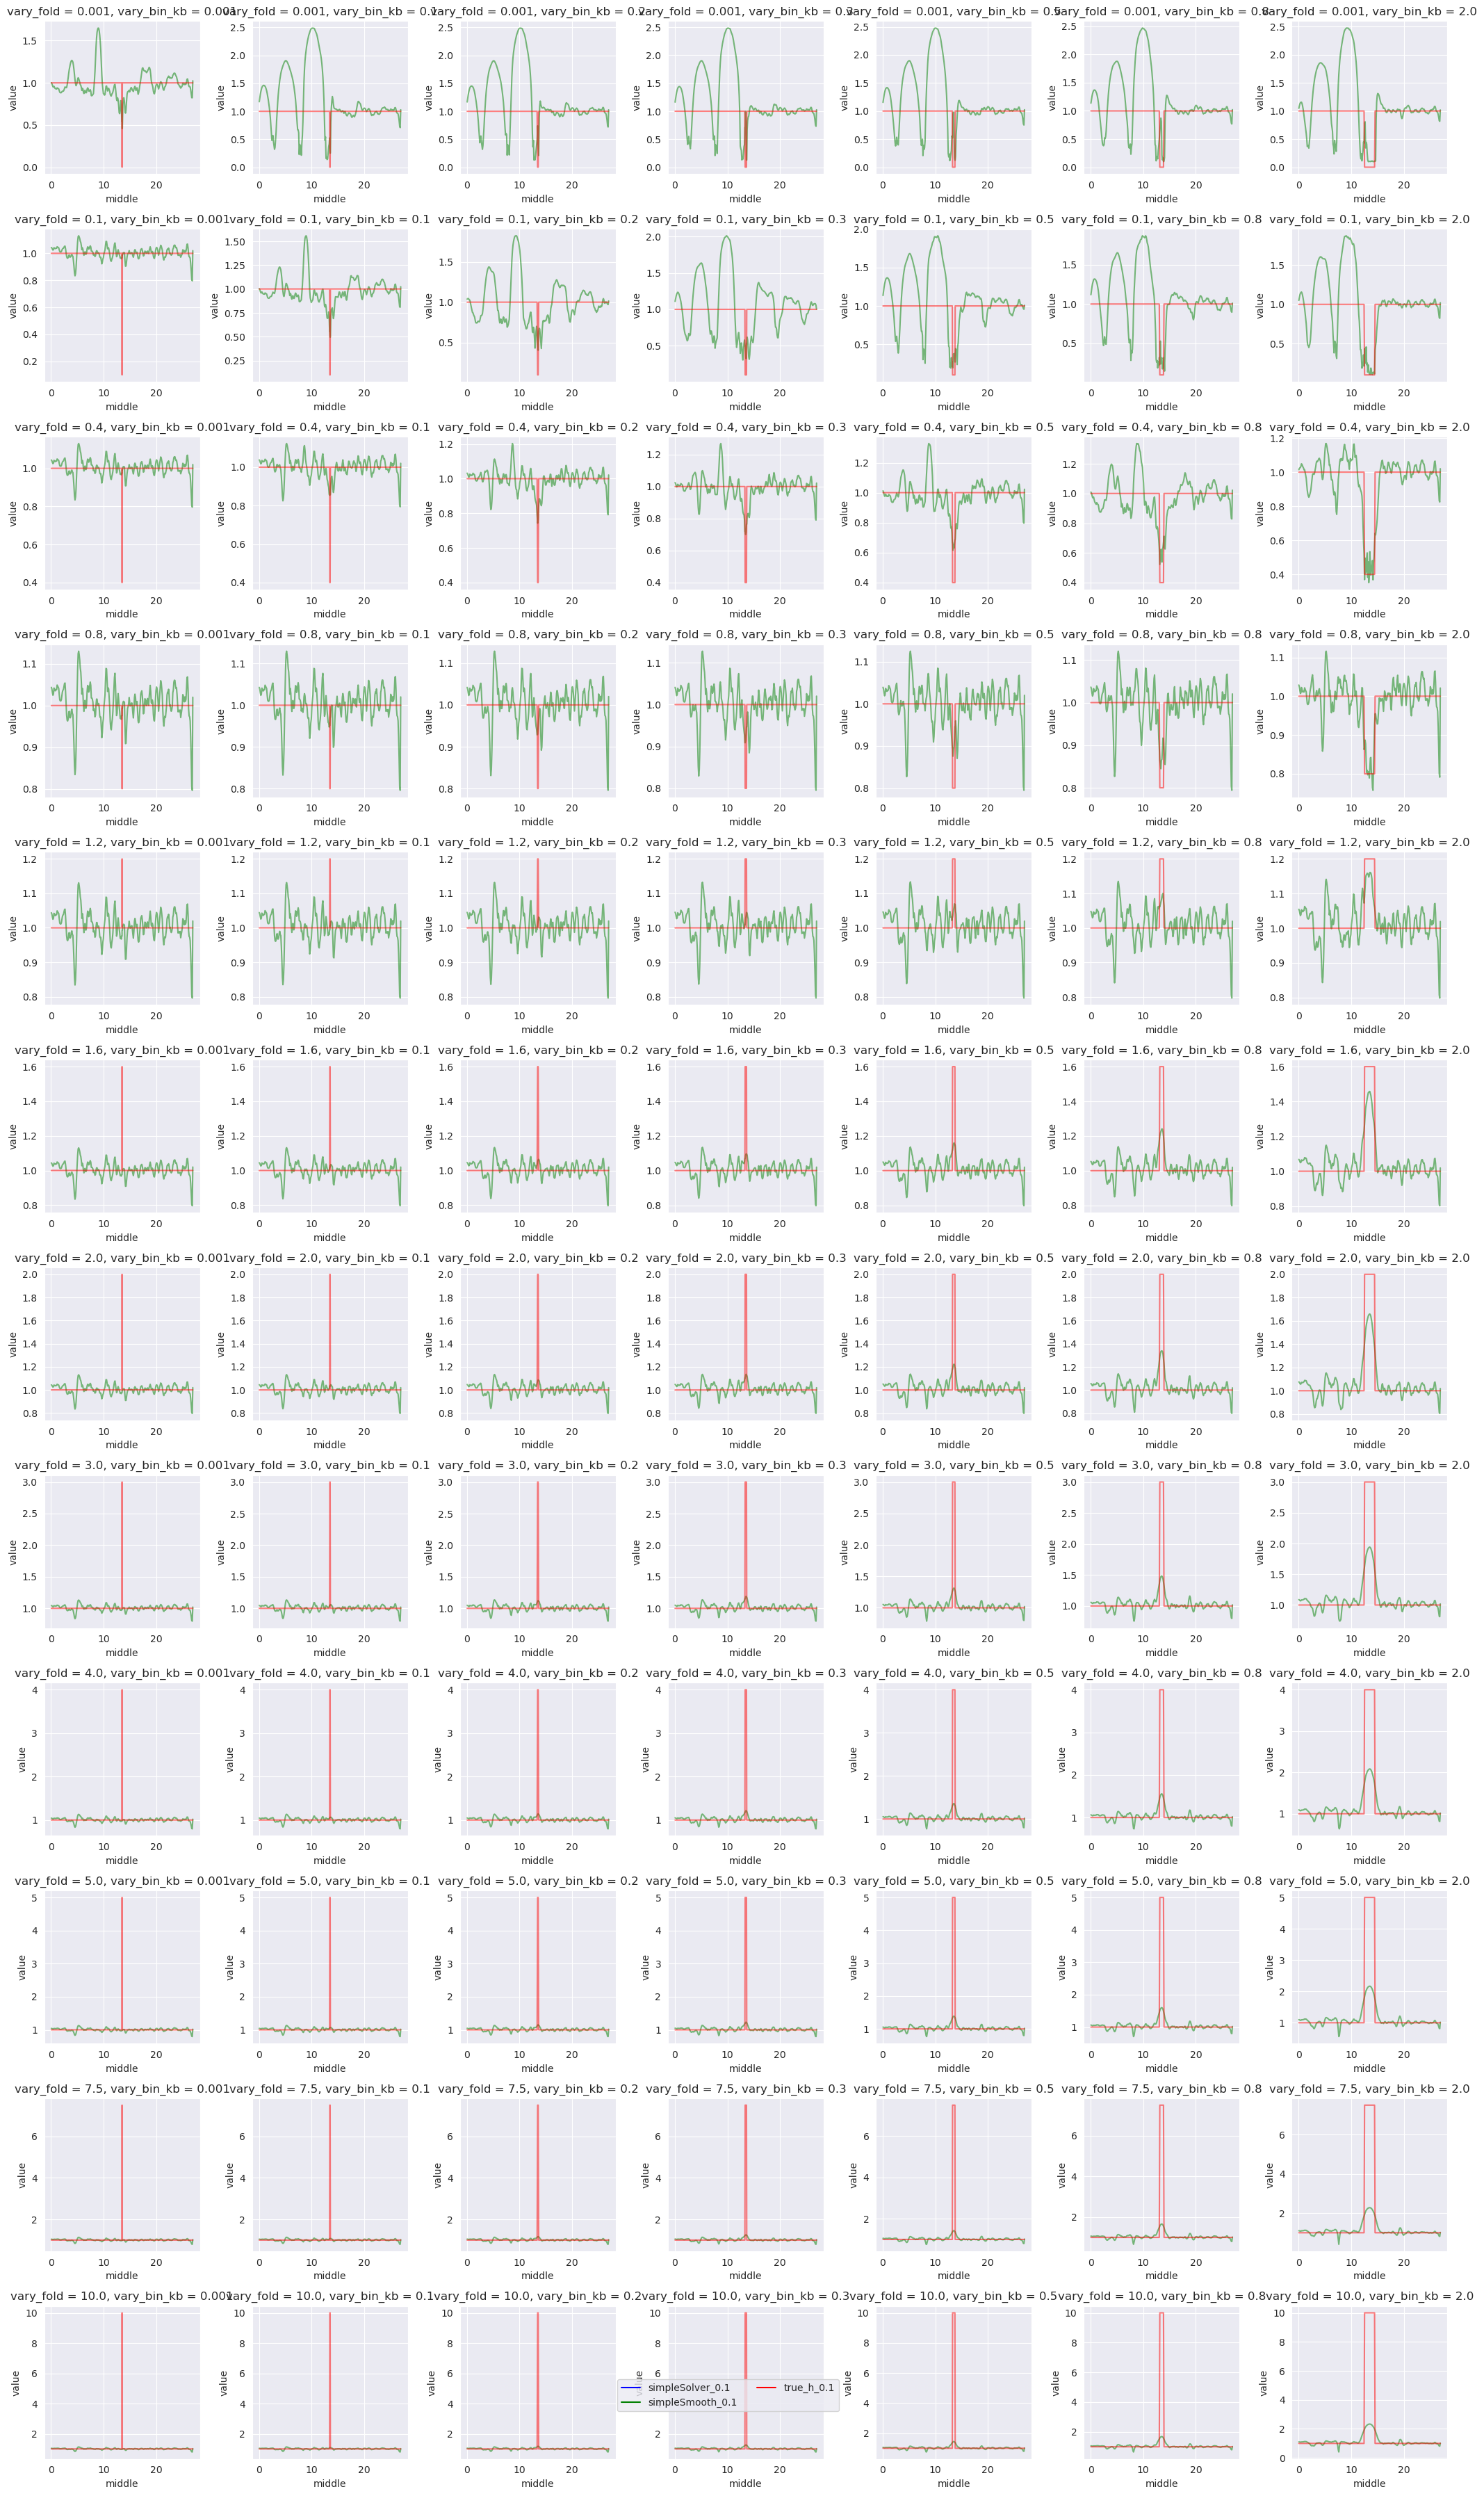

(<Figure size 2100x3600 with 84 Axes>,
 array([[<Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 0.001'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 0.1'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 0.2'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 0.3'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 0.5'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 0.8'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.001, vary_bin_kb = 2.0'}, xlabel='middle', ylabel='value'>],
        [<Axes: title={'center': 'vary_fold = 0.1, vary_bin_kb = 0.001'}, xlabel='middle', ylabel='value'>,
         <Axes: title={'center': 'vary_fold = 0.1, vary_bin_kb = 0.1'}, xlabel='middle', ylabe

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
def get_color_dict(plot_df):
    '''
    Get a color dictionary for different methods and h_bin
    '''
    uniq_lambda = plot_df['lambda_smooth'].astype(str).unique()
    # Assign colors to method_binH combinations
    blue_palette = sns.light_palette("blue", reverse=False, n_colors=len(uniq_lambda)+1)
    green_palette = sns.light_palette("green", reverse=False, n_colors=len(uniq_lambda)+1)
    red_color = "red"
    color_dict = {}
    for l_idx, lambda_smooth in enumerate(uniq_lambda):
        color_dict[f'simpleSolver_{lambda_smooth}'] = blue_palette[l_idx+1]  # Map to blue shades
        color_dict[f'simpleSmooth_{lambda_smooth}'] = green_palette[l_idx+1]  # Map to green shades
    color_dict['true_h_0.1'] = red_color
    return color_dict

def question5_plot1(run_df, bin_h = 0.1, methods=['simpleSmooth', 'simpleSolver'], save_fn=None):
    '''
    There are different subplots corresponding to different vary_fold and vary_bin_kb
    For each subplot:
    - x-axis: avg of start and end
    - y-axis: simpleSmooth predictions, along with true_h  
    '''
    plot_df = run_df[run_df['h_bin'] == bin_h].copy()
    vary_fold_list = plot_df['vary_fold'].unique()
    vary_bin_list = plot_df['vary_bin_kb'].unique()
    fig, axs = plt.subplots(len(vary_fold_list), len(vary_bin_list), figsize=(len(vary_bin_list)* 3, len(vary_fold_list)*3))
    color_dict = get_color_dict(plot_df)
    
    handles_labels = {} # To store legend handles and labels
    for i, vary_fold in enumerate(vary_fold_list):
        for j, vary_bin_kb in enumerate(vary_bin_list):
            ax = axs[i,j]
            sub_df = plot_df[(plot_df['vary_fold'] == vary_fold) & (plot_df['vary_bin_kb']==vary_bin_kb)].copy()
            sub_df['middle'] = (sub_df['start'] + sub_df['end']) / 2
            melt_df = pd.melt(
                sub_df,
                id_vars=['middle', 'lambda_smooth'],
                value_vars=methods + ['true_h'],
                var_name='method',
                value_name='value'
            )
            # Filter rows where true_h has non-default h_bin
            melt_df = melt_df[~((melt_df['method'] == 'true_h') & (melt_df['lambda_smooth'] != 0.1))]
            melt_df = melt_df[~((melt_df['method'] == 'simpleSolver') & (melt_df['lambda_smooth'] != 0.1))]
            melt_df['method_lambda'] = melt_df['method'] + '_' + melt_df['lambda_smooth'].astype(str)
            sns.lineplot(
                x='middle', y='value', hue='method_lambda', data=melt_df, ax=ax,
                palette=color_dict, legend=False, alpha= 0.5
            )
            ax.set_title(f'vary_fold = {vary_fold}, vary_bin_kb = {vary_bin_kb}')
            for method_binH, color in color_dict.items():
                handles_labels[method_binH], = ax.plot([], [], label=method_binH, color=color)
    # Filter out duplicates for the shared legend
    fig.legend(handles_labels.values(), handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)
    plt.tight_layout()
    if save_fn:
        plt.savefig(save_fn)
    plt.show()
    return fig, axs


question5_plot1(run_df, save_fn = f'{output_folder}/question5_plot1.png', methods = ['simpleSmooth'],  bin_h =0.1)

In [8]:
# plot5: Compare the performance of different solvers, across different true_h for only one case:
def vary_start_end_site(G, vary_bin_kb, window=1):
    '''
    Given gene length, and the vary_bin_kb that is a region in the middle of the gene, get the start and end of the region (plus/minus window at the start and end)
    :param G: 
    :param vary_bin_kb: 
    :param window: 
    :return: 
    '''
    middle = G / 2
    start = middle - vary_bin_kb / 2
    end = middle + vary_bin_kb / 2
    start = max(0, start - window)
    end = min(G, end + window)
    return start, end

def read_one_result_aroundVary(fn, summ_df, methods = ['simpleSolver', 'simpleSmooth', 'bayesLinearSolver', 'bayesRBFSolver', 'logNormalSolver']):
    '''
    Read one result file and return the results as a dictionary
    :param fn: str, the filename
    :return: dict
    '''
    df = pd.read_csv(fn, sep='\t', header=0, index_col=None)  # start, end, true_h and then all the diffemrent solver results
    file_index = int(fn.split('/')[-1].split('.')[0].split('_')[-1])
    try:
        df = df.rename(columns={'txrate': 'true_h'})
    except:
        pass
    h_bin =summ_df.loc[file_index, 'h_bin']
    lambda_smooth = summ_df.loc[file_index, 'lambda_smooth']
    vary_fold = summ_df.loc[file_index, 'vary_fold']
    vary_bin_kb = summ_df.loc[file_index, 'vary_bin_kb']
    G= summ_df.loc[file_index, 'G']
    df['h_bin'] = h_bin
    df['lambda_smooth'] = lambda_smooth
    df['vary_fold'] = vary_fold
    df['vary_bin_kb'] = vary_bin_kb
    start, end = vary_start_end_site(G, vary_bin_kb)
    df = df[(df['start'] >= start) & (df['end'] <= end)] # filter only regions around vary_bin_kb
    return df

run_fn_list = [f'{input_folder}/result_{i}.txt.gz' for i in range(len(fn_list))]
run_df_list = list(map(lambda x: read_one_result_aroundVary(x, result_df, methods = ['simpleSmooth']), run_fn_list))
run_df = pd.concat(run_df_list)

/tmp/ipykernel_614273/1649492270.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_df = plot_df.groupby(['vary_fold', 'vary_bin_kb']).apply(


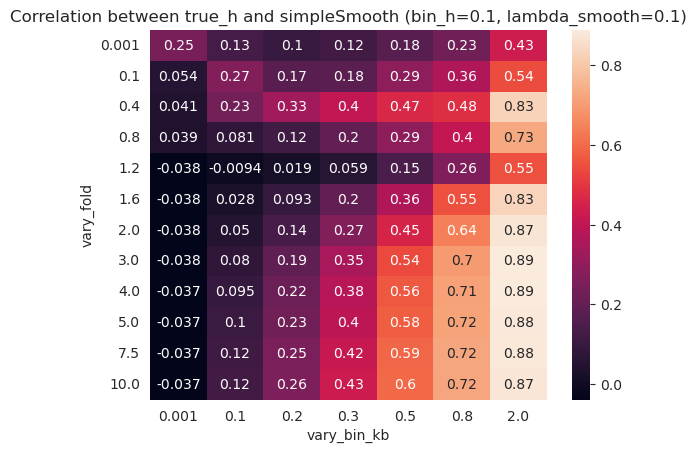

In [9]:
def question5_plot2(run_df, methods = 'simpleSmooth', save_fn = None, bin_h = 0.1, lambda_smooth = 0.1):
    '''
    Heatmap with
    - x-axis: vary-fold
    - y-axis: vary-bin-kb
    - color: correlation between true_h and simpleSmooth
    :param run_df: 
    :param methods: 
    :param save_fn: 
    :param bin_h: 
    :return: 
    '''
    plot_df = run_df[(run_df['h_bin'] == bin_h) & (run_df['lambda_smooth'] == lambda_smooth)].copy()
    vary_fold_list = plot_df['vary_fold'].unique()
    vary_bin_list = plot_df['vary_bin_kb'].unique()
    corr_df = plot_df.groupby(['vary_fold', 'vary_bin_kb']).apply(
        lambda group: group['true_h'].corr(group['simpleSmooth'])
    ).reset_index(name='correlation')
    corr_df = corr_df.pivot(index='vary_fold', columns='vary_bin_kb', values='correlation')
    sns.heatmap(corr_df, annot=True)
    plt.title(f'Correlation between true_h and simpleSmooth (bin_h={bin_h}, lambda_smooth={lambda_smooth})')
    if save_fn:
        plt.savefig(save_fn)
    plt.show()
    return corr_df

corr_df = question5_plot2(run_df, save_fn = f'{output_folder}/question5_plot2.png', methods = ['simpleSmooth'],  bin_h =0.1, lambda_smooth = 0.1)